<a href="https://colab.research.google.com/github/misbahsy/APMonitor-do/blob/master/ControllerObjective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dynamic Control Objectives

<p class='vspace'>The dynamic control objective function is a mathematical statement that is minimized or maximized to find a best solution among all possible feasible solutions for a controller. The form of this objective function is critical to give desirable solutions for driving a system to a desirable state or along a desired trajectory. Common objective statements relate to economic, safety, operability, environmental, or related objectives.
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/mpc_objectives.zip' rel='nofollow'>MPC Objective Exercise (Python and MATLAB)</a></div>
<div class='vspace'></div>

In [1]:
#@title
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/dM8gX54jWW4" frameborder="0" allowfullscreen></iframe> 


apm 35.230.39.168_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            4
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:            720
 Number of total equations: -          680
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             40
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

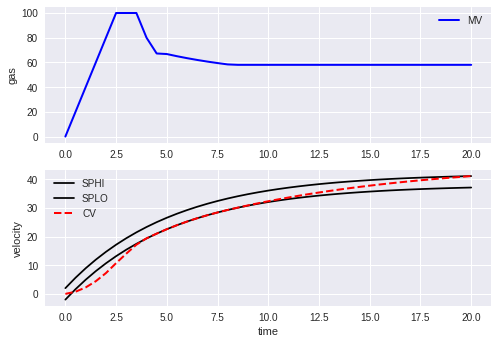

In [2]:
#@markdown MPC with GEKKO

import numpy as np
from random import random
from gekko import GEKKO
import matplotlib.pyplot as plt

# initialize GEKKO model
m = GEKKO()

# time
m.time = np.linspace(0,20,41)

# constants
mass = 500

# Parameters
b = m.Param(value=50)
K = m.Param(value=0.8)
# Manipulated variable
p = m.MV(value=0, lb=0, ub=100)

# Controlled Variable
v = m.CV(value=0,name='v')

# Equations
m.Equation(mass*v.dt() == -v*b + K*b*p)

m.options.IMODE = 6 # control

# MV tuning
p.STATUS = 1 #allow optimizer to change
p.DCOST = 0.1 #smooth out MV
p.DMAX = 20 #slow down change of MV

# CV tuning
v.STATUS = 1 #add the CV to the objective
m.options.CV_TYPE = 1 #Dead-band
v.SPHI = 42 #set point
v.SPLO = 38 #set point
v.TR_INIT = 1 #setpoint trajectory
v.TAU = 5 #time constant of setpoint trajectory

# Solve
m.solve()

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)

# Plot solution
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,p.value,'b-',LineWidth=2,label='MV')
plt.legend(loc='best')
plt.ylabel('gas')
plt.subplot(2,1,2)
plt.plot(m.time,results['v.tr_lo'],'k-',label='SPHI')
plt.plot(m.time,results['v.tr_hi'],'k-',label='SPLO')
plt.plot(m.time,v.value,'r--',LineWidth=2,label='CV')
plt.legend(loc='best')
plt.ylabel('velocity')
plt.xlabel('time')
plt.show()


<p class='vspace'>Two common objective functions are shown below as squared error and l<sub>1</sub>-norm forms<sup>1</sup>.
</p>
<div class='vspace'></div>

##Squared Error Objective

<p>The squared error objective is the most common form used in the literature. It penalizes deviation of the current measured value of the controlled variable from the desired target value.
</p>
<p class='vspace'>$$\min_{x,y,u} \Phi = \left(y-y_t\right)^T W_t \left(y-y_t\right) + y^T w_y + u^T w_u + \Delta u^T W_{\Delta u} \Delta u$$
</p>
<p class='vspace'>$$\mathrm{subject\;\;to}$$
</p>
<p class='vspace'>$$0 = f\left(\frac{dx}{dt},x,y,u\right)$$
</p>
<p class='vspace'>$$0 \le g\left(\frac{dx}{dt},x,y,u\right)$$
</p>
<p class='vspace'>$$\tau_c \frac{dy_t}{dt} + y_t = sp$$
</p>
<div class='vspace'></div>

##l<sub>1</sub>-norm Objective

<p>The l<sub>1</sub>-norm objective is the absolute value of the difference between the current measured value of the controlled variable and the desired target value. The absolute value operator (abs(x)) does not have a continuous first and second derivative at x=0 (see <a class='urllink' href='https://apmonitor.com/me575/index.php/Main/LogicalConditions' rel='nofollow'>absolute value function alternatives</a>). <a class='urllink' href='https://apmonitor.com/wiki/index.php/Main/SlackVariables' rel='nofollow'>Slack variables</a> give the same absolute value function but with continuous first and second derivatives.
</p>
<p class='vspace'>$$\min_{x,y,u} \Phi = w_{hi}^T e_{hi} + w_{lo}^T e_{lo} + y^T w_y + u^T w_u + w_{\Delta u}^T \left(\Delta u_U+\Delta u_L\right)$$
</p>
<p class='vspace'>$$\mathrm{subject\;\;to}$$
</p>
<p class='vspace'>$$0 = f\left(\frac{dx}{dt},x,y,u\right)$$
</p>
<p class='vspace'>$$0 \le g\left(\frac{dx}{dt},x,y,u\right)$$
</p>
<p class='vspace'>$$\tau_c \frac{dy_{t,hi}}{dt} + y_{t,hi} = sp_{hi}$$
</p>
<p class='vspace'>$$\tau_c \frac{dy_{t,lo}}{dt} + y_{t,lo} = sp_{lo}$$
</p>
<p class='vspace'>$$e_{hi} \ge y - y_{t,hi}$$
</p>
<p class='vspace'>$$e_{lo} \ge y_{t,lo} - y$$
</p>
<p class='vspace'>$$\Delta u_U \ge u_i - u_{i-1}$$
</p>
<p class='vspace'>$$\Delta u_L \ge u_{i-1} - u_i$$
</p>
<p class='vspace'>$$e_{hi}, e_{lo}, \Delta u_U, \Delta u_L \ge 0$$
</p>
<div class='vspace'></div>

##Nomenclature

<p>$$\Phi=\mathrm{Objective\,Function}$$
</p>
<p class='vspace'>$$y=\mathrm{model\,predictions}$$
</p>
<p class='vspace'>$$y_t,y_{t,hi},y_{t,lo}=\mathrm{reference\,trajectory\,or\,range}$$
</p>
<p class='vspace'>$$W_t,w_{hi}, w_{lo}=\mathrm{penalty\,outside\,reference\,trajectory\,(WSP,WSPHI,WSPLO)}$$
</p>
<p class='vspace'>$$W_{\Delta u}, w_{\Delta u}=\mathrm{manipulated\,variable\,movement\,penalty\,(DCOST)}$$
</p>
<p class='vspace'>$$w_{u}, w_{y}=\mathrm{weight\,on\,input\,and\,output\,(COST)}$$
</p>
<p class='vspace'>$$y,x,u=\mathrm{outputs,\,states,\,and\,inputs}$$
</p>
<p class='vspace'>$$\Delta u=\mathrm{manipulated\,variable\,change}$$
</p>
<p class='vspace'>$$f,g=\mathrm{equality\,and\,inequality\,constraints}$$
</p>
<p class='vspace'>$$e_{hi},e_{lo}=\mathrm{upper\,and\,lower\,error\,outside\,dead-band}$$
</p>
<p class='vspace'>$$\Delta u_U,\Delta u_L=\mathrm{upper\,and\,lower\,manipulated\,variable\,change}$$
</p>
<p class='vspace'>In formulating an objective function and model equations follow the following tips for improved convergence.
</p>
<div class='vspace'></div><ol><li>Rearrange to equation in residual form to:
<ol><li>Avoid divide by zero
</li><li>Minimize use of functions like sqrt, log, exp, etc.
</li><li>Have continuous first and second derivatives
</li><li>Fit the equation into a linear or quadratic form
</li></ol></li><li>Bounds
<ol><li>Include variable bounds to exclude infeasible solutions
</li><li>Variable bounds to avoid regions of strong nonlinearity 
</li><li>Caution: watch for infeasible solutions
</li></ol></li><li>Scaling:
<ol><li>Scale absolute value of variables to 1e-3 to 1e3
</li><li>Scale absolute value of equation residuals to 1e-3 to 1e3
</li><li>Better that 1st derivative values are closer to 1.0
</li></ol></li><li>Good initial conditions:
<ol><li>Starting near a solution can improve convergence
</li><li>Try multiple initial conditions to verify global solution (non-convex problems)
</li><li>Explicitly calculate intermediate values
</li></ol></li><li>Check iteration summary for improved convergence  
</li></ol><div class='vspace'></div>

##Custom Reference Trajectory

<p>Some applications require a custom reference trajectory that does not fit a standard form. A custom reference trajectory is specified by creating a new error (e) variable that is the difference between the specified trajectory (sinusoidal, sawtooth, random, etc) and the model output. This error is specified as a controlled variable (CV) with an upper and lower dead-band denoted as SPHI and SPLO. The CV can also be a value of zero with a squared error objective (e.SP=0, m.options.CV_TYPE=2) to drive to a target instead of a dead-band range.
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/custom_traj.zip' rel='nofollow'>Custom Reference Trajectory (Python and MATLAB)</a></div>
<div class='vspace'></div><div><img width='500px' src='http://apmonitor.com/do/uploads/Main/gekko_traj.png' alt='' title='' /></div>

apm 35.230.39.168_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            6
   Intermediates:            0
   Connections  :            0
   Equations    :            2
   Residuals    :            2
 
 Number of state variables:            760
 Number of total equations: -          720
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             40
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

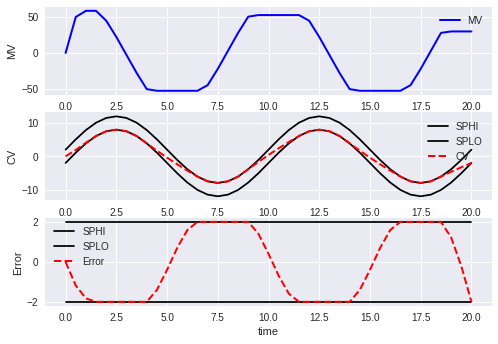

In [3]:
#@markdown Custom Reference Trajectory with GEKKO

import numpy as np
from random import random
from gekko import GEKKO
import matplotlib.pyplot as plt

# initialize GEKKO model
m = GEKKO()

# time
m.time = np.linspace(0,20,41)

# constants
mass = 500

# Parameters
b = m.Param(value=50)
K = m.Param(value=0.8)
# Manipulated variable
p = m.MV(value=0, lb=-100, ub=100)

# Reference trajectory
sine = 10*np.sin(m.time/20*4*np.pi)
traj = m.Param(value=sine)

# Controlled Variable
v = m.SV(value=0,name='v')

# Error
e = m.CV(value=0,name='e')

# Equations
m.Equation(mass*v.dt() == -v*b + K*b*p)
m.Equation(e==v-traj)

m.options.IMODE = 6 # control

# MV tuning
p.STATUS = 1 #allow optimizer to change
p.DCOST = 0.1 #smooth out MV
p.DMAX = 50 #slow down change of MV

# CV tuning
e.STATUS = 1 #add the CV to the objective
m.options.CV_TYPE = 1 #Dead-band
db = 2
e.SPHI = db #set point
e.SPLO = -db #set point
e.TR_INIT = 0 #setpoint trajectory
e.TAU = 5 #time constant of setpoint trajectory

# Solve
m.solve()

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)

# Plot solution
plt.figure()
plt.subplot(3,1,1)
plt.plot(m.time,p.value,'b-',LineWidth=2,label='MV')
plt.legend(loc='best')
plt.ylabel('MV')
plt.subplot(3,1,2)
plt.plot(m.time,sine+db,'k-',label='SPHI')
plt.plot(m.time,sine-db,'k-',label='SPLO')
plt.plot(m.time,v.value,'r--',LineWidth=2,label='CV')
plt.legend(loc='best')
plt.ylabel('CV')
plt.subplot(3,1,3)
plt.plot(m.time,results['e.tr_hi'],'k-',label='SPHI')
plt.plot(m.time,results['e.tr_lo'],'k-',label='SPLO')
plt.plot(m.time,e.value,'r--',LineWidth=2,label='Error')
plt.legend(loc='best')
plt.ylabel('Error')
plt.xlabel('time')
plt.show()